In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prim
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
#import graphviz # for plotting decision tree graphs

In [19]:
hour24_neighbor =  pd.read_csv ("data/NO_storm_damage_by_neighborhood_long_24_hours.csv")
neighbor_structure_value = pd.read_csv ("data/No_value_by_neighborhood_long.csv")



hour24_neighbor = hour24_neighbor.loc[(hour24_neighbor['recurrence'] == 'EAD') & (hour24_neighbor['threshold'] == '>12in')]
hour24_neighbor = hour24_neighbor.drop(["recurrence", "threshold"], axis = 1)
hour24_neighbor = hour24_neighbor.groupby(["Scenario"]).damage.sum().reset_index()


neighbor_structure_value = neighbor_structure_value.value.sum()




In [20]:
results = hour24_neighbor


results['damage_percent'] = (results ['damage']/neighbor_structure_value)*100

results['vulnerable'] = np.where(results['damage_percent']>2, True, False)

In [21]:
scenario_df= pd.read_csv ("data/NO_Storm_Water_Design_Compact.csv")


df = results
df = df[['Scenario','vulnerable']]

logistic_data= df.merge(scenario_df, left_on="Scenario", right_on="Scenario")

logistic_data.drop (['Scenario','Scenario'], axis=1, inplace=True)

rainfall=pd.get_dummies(logistic_data['rainfall'], drop_first=False)
rainfall = rainfall.drop(['Present'], axis = 1)
SLR=pd.get_dummies(logistic_data['SLR'], drop_first=True)
SLR.rename(columns={0.0: "SLR_0.0", 0.2795: "SLR_0.2795", 0.7835:"SLR_0.7835", 1.0355:"SLR_0.7835"}, inplace=True)
roughness=pd.get_dummies(logistic_data['roughness'], drop_first=True)
roughness.rename(columns={'100%': "Rough_100", '50%': "Rough_50", '75%':"Rough_75", '25%':"Rough_25"}, inplace=True)
DPS_1_2=pd.get_dummies(logistic_data['DPS_1_2'], drop_first=False)
DPS_1_2.rename(columns={0.0: "DPS_1_2_0.0", 0.5: "DPS_1_2_0.5", 1.0: "DPS_1_2_1.0"}, inplace=True)
DPS_1_2 = DPS_1_2.drop(['DPS_1_2_1.0'], axis=1)
DPS_All_Other=pd.get_dummies(logistic_data['DPS_All_Other'], drop_first=False)
DPS_All_Other.rename(columns={0.0: "DPS_All_Other_0.0", 0.5: "DPS_All_Other_0.5", 1.0: "DPS_All_Other_1.0"}, inplace=True)
DPS_All_Other = DPS_All_Other.drop(['DPS_All_Other_1.0'], axis=1)

logistic_data.drop (['rainfall','SLR','roughness', 'DPS_1_2', 'DPS_All_Other'], axis=1, inplace=True)
logistic_data=pd.concat([logistic_data,rainfall,roughness,DPS_1_2,DPS_All_Other], axis=1)

labels = pd.DataFrame(logistic_data['vulnerable'])
logistic_data=logistic_data.drop(['vulnerable'], axis=1)
print(logistic_data.head())
logistic_data=logistic_data.apply(pd.to_numeric)
labels=labels.apply(pd.to_numeric)



   Kunkel 2045 4.5  Kunkel 2075 4.5  Kunkel 2075 8.5  Rough_100  Rough_25  \
0                0                0                0          0         0   
1                1                0                0          0         0   
2                0                1                0          0         0   
3                0                1                0          0         0   
4                0                0                1          0         0   

   Rough_50  Rough_75  DPS_1_2_0.0  DPS_1_2_0.5  DPS_All_Other_0.0  \
0         0         0            0            0                  0   
1         0         0            0            0                  0   
2         0         0            0            0                  0   
3         0         0            0            0                  0   
4         0         0            0            0                  0   

   DPS_All_Other_0.5  
0                  0  
1                  0  
2                  0  
3                  0  
4

              precision    recall  f1-score   support

       False       0.80      0.97      0.88        40
        True       0.99      0.91      0.95       110

    accuracy                           0.93       150
   macro avg       0.89      0.94      0.91       150
weighted avg       0.94      0.93      0.93       150

[0.3969376  1.09989308 3.51413671 0.85446088 0.01978426 0.01978426
 0.40703535 2.94265562 0.08200624 1.18524767 1.56233294]
[-2.51977338]
                   importance
Kunkel 2045 4.5      0.396938
Kunkel 2075 4.5      1.099893
Kunkel 2075 8.5      3.514137
Rough_100            0.854461
Rough_25             0.019784
Rough_50             0.019784
Rough_75             0.407035
DPS_1_2_0.0          2.942656
DPS_1_2_0.5          0.082006
DPS_All_Other_0.0    1.185248
DPS_All_Other_0.5    1.562333
Index(['Kunkel 2045 4.5', 'Kunkel 2075 4.5', 'Kunkel 2075 8.5', 'Rough_100',
       'Rough_25', 'Rough_50', 'Rough_75', 'DPS_1_2_0.0', 'DPS_1_2_0.5',
       'DPS_All_Other_0.0

c:\Users\pkane\.conda\envs\prj-lmr-scistack\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 0, 'score')

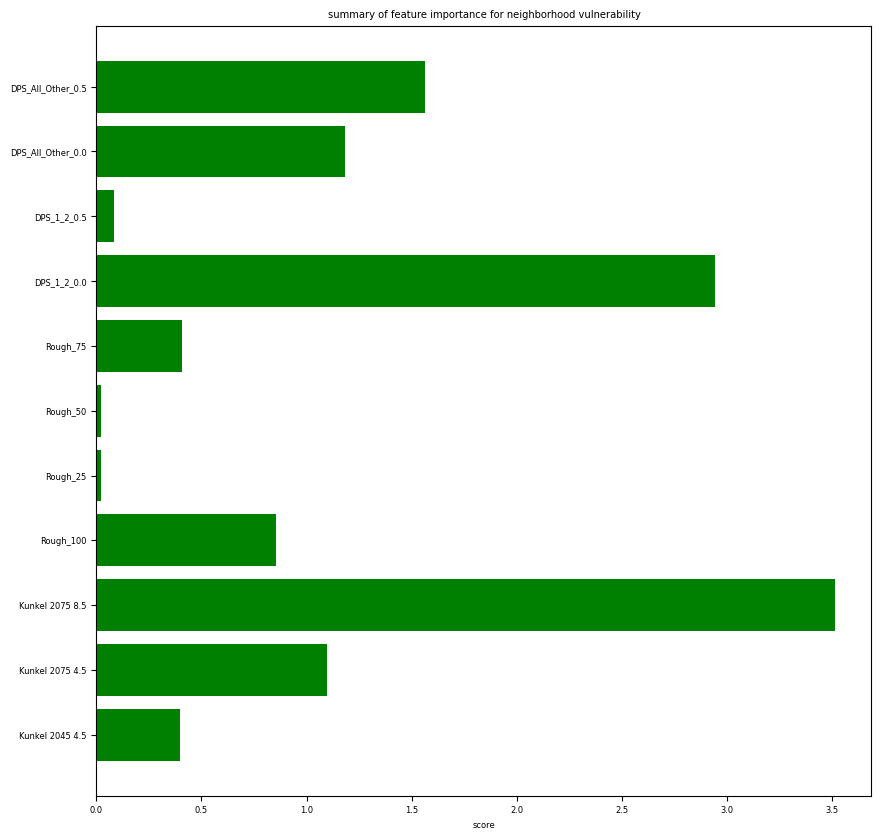

In [22]:
X_train = logistic_data
y_train = labels

logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train, y_train)
predictions_log = logmodel.predict (X_train)

print(classification_report(y_train, predictions_log))

importance = logmodel.coef_.flatten()
#importance = importance.astype(str)
print(importance)
print(logmodel.intercept_)
features=logistic_data.columns.astype(str)

importance_df = pd.DataFrame (importance, columns = ['importance'], index=features)
print (importance_df)
importance_df['importance_abs']= importance_df['importance'].abs()
importance_df=importance_df.sort_values('importance_abs',  ascending=[False])
importance_df.to_csv('outputs/feature_importance_all_scenarios_Broadmoor.csv')

print(logistic_data.columns)
plt.rcParams["figure.figsize"]= (10,10)
plt.rcParams.update({'font.size': 6})
plt.barh(logistic_data.columns.astype(str), importance, color = 'g')
plt.title("summary of feature importance for neighborhood vulnerability")
plt.xlabel ("score")

In [30]:
print(np.exp(logmodel.intercept_))
importance_df = pd.DataFrame (np.exp(importance), columns = ['importance'], index=features)
print (importance_df)


[0.08047784]
                   importance
Kunkel 2045 4.5      1.487263
Kunkel 2075 4.5      3.003845
Kunkel 2075 8.5     33.586920
Rough_100            2.350107
Rough_25             1.019981
Rough_50             1.019981
Rough_75             1.502357
DPS_1_2_0.0         18.966146
DPS_1_2_0.5          1.085463
DPS_All_Other_0.0    3.271497
DPS_All_Other_0.5    4.769936


In [24]:
def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    X_train = X
    X_test = X
    y_train = y
    y_test = y
        # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                            splitter=splitter, 
                                            max_depth=mdepth,
                                            class_weight=clweight,
                                            min_samples_leaf=minleaf, 
                                            random_state=0, 
                                    )
    clf = model.fit(X_train, y_train)
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

        # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    #print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')

        # Use graphviz to plot the tree
    # dot_data = tree.export_graphviz(clf, out_file="tree.dot", 
    #                                 feature_names=X.columns, 
    #                                 class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
    #                                 filled=True, 
    #                                 rounded=True, 
    #                                 #rotate=True,
    #                             ) 
    # graph = graphviz.Source(dot_data)
    r = tree.export_text(clf, feature_names=X.columns.tolist(), show_weights=True)


    return X_train, X_test, y_train, y_test, clf, r 



X_train, X_test, y_train, y_test, clf, r = fitting(logistic_data, labels,  'gini', 'best', 
                                                       mdepth=3, 
                                                       clweight=None,
                                                       minleaf=5)

# Plot the tree graph



*************** Tree Summary ***************
Classes:  [False  True]
Tree Depth:  3
No. of leaves:  6
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.92
              precision    recall  f1-score   support

       False       0.85      0.85      0.85        40
        True       0.95      0.95      0.95       110

    accuracy                           0.92       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.92      0.92      0.92       150

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.92
              precision    recall  f1-score   support

       False       0.85      0.85      0.85        40
        True       0.95      0.95      0.95       110

    accuracy                           0.92       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.92

In [25]:
print(r)

|--- DPS_1_2_0.0 <= 0.50
|   |--- Kunkel 2075 8.5 <= 0.50
|   |   |--- DPS_All_Other_0.5 <= 0.50
|   |   |   |--- weights: [34.00, 6.00] class: False
|   |   |--- DPS_All_Other_0.5 >  0.50
|   |   |   |--- weights: [5.00, 15.00] class: True
|   |--- Kunkel 2075 8.5 >  0.50
|   |   |--- weights: [0.00, 30.00] class: True
|--- DPS_1_2_0.0 >  0.50
|   |--- DPS_All_Other_0.0 <= 0.50
|   |   |--- Kunkel 2075 8.5 <= 0.50
|   |   |   |--- weights: [1.00, 19.00] class: True
|   |   |--- Kunkel 2075 8.5 >  0.50
|   |   |   |--- weights: [0.00, 10.00] class: True
|   |--- DPS_All_Other_0.0 >  0.50
|   |   |--- weights: [0.00, 30.00] class: True



In [26]:
prim_data= df.merge(scenario_df, left_on="Scenario", right_on="Scenario")

prim_data.drop (['Scenario','Scenario'], axis=1, inplace=True)

prim_data['rainfall'].replace(['Present', 'Kunkel 2045 4.5', 'Kunkel 2075 4.5', 'Kunkel 2075 8.5'], [0, 1, 2, 3], inplace=True)
prim_data['roughness'].replace(['0%', '25%', '50%', '75%', '100%'], [0, 25, 50, 75, 100], inplace=True)
prim_data.drop(['SLR'], axis=1, inplace=True)

labels = pd.DataFrame(prim_data['vulnerable'])
prim_data.drop(['vulnerable'], axis=1, inplace=True)
print(prim_data.head())
prim_data=prim_data.apply(pd.to_numeric)
labels=labels.apply(pd.to_numeric)

   rainfall  roughness  DPS_1_2  DPS_All_Other
0         0          0      1.0            1.0
1         1          0      1.0            1.0
2         2          0      1.0            1.0
3         2          0      1.0            1.0
4         3          0      1.0            1.0


In [27]:
X_train, X_test, y_train, y_test, clf, r = fitting(prim_data, labels,  'gini', 'best', 
                                                       mdepth=3, 
                                                       clweight=None,
                                                       minleaf=5)

*************** Tree Summary ***************
Classes:  [False  True]
Tree Depth:  3
No. of leaves:  6
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.92
              precision    recall  f1-score   support

       False       0.85      0.85      0.85        40
        True       0.95      0.95      0.95       110

    accuracy                           0.92       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.92      0.92      0.92       150

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.92
              precision    recall  f1-score   support

       False       0.85      0.85      0.85        40
        True       0.95      0.95      0.95       110

    accuracy                           0.92       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.92

In [28]:
print(r)

|--- DPS_1_2 <= 0.25
|   |--- rainfall <= 0.50
|   |   |--- DPS_All_Other <= 0.50
|   |   |   |--- weights: [0.00, 5.00] class: True
|   |   |--- DPS_All_Other >  0.50
|   |   |   |--- weights: [1.00, 4.00] class: True
|   |--- rainfall >  0.50
|   |   |--- weights: [0.00, 50.00] class: True
|--- DPS_1_2 >  0.25
|   |--- rainfall <= 2.50
|   |   |--- DPS_All_Other <= 0.75
|   |   |   |--- weights: [5.00, 15.00] class: True
|   |   |--- DPS_All_Other >  0.75
|   |   |   |--- weights: [34.00, 6.00] class: False
|   |--- rainfall >  2.50
|   |   |--- weights: [0.00, 30.00] class: True



Box 1 [Peeling Trajectory 3]
    Stats
        Coverage: 0.454545
        Density:  1.000000
        Mass:     0.333333
        Res Dim:  2.000000
        Mean:     1.000000
    Limits
                  min   max  qp values
        DPS_1_2   0.0  0.25   0.000023
        rainfall  1.0  3.00   0.431557


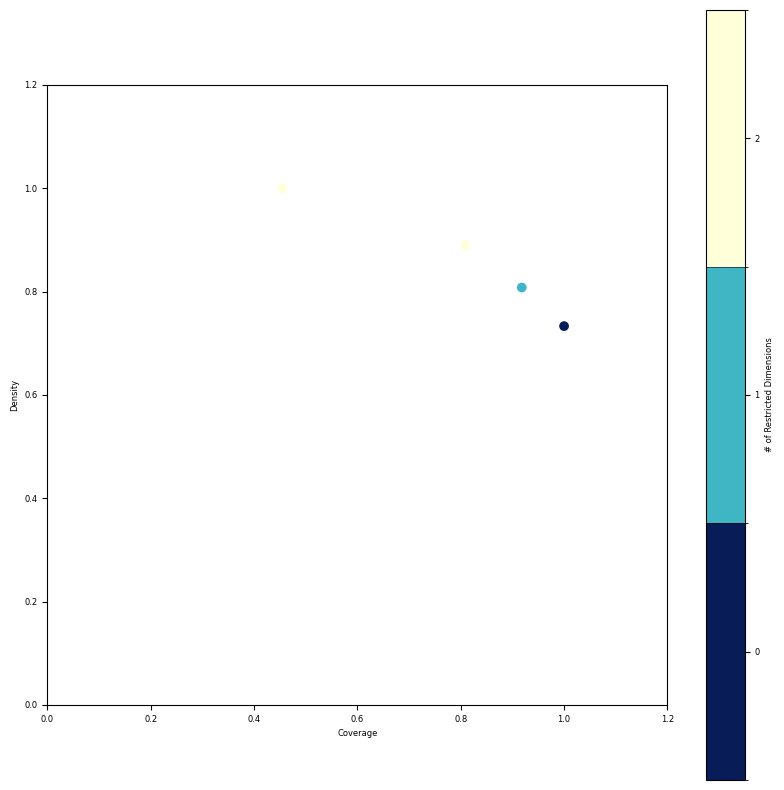

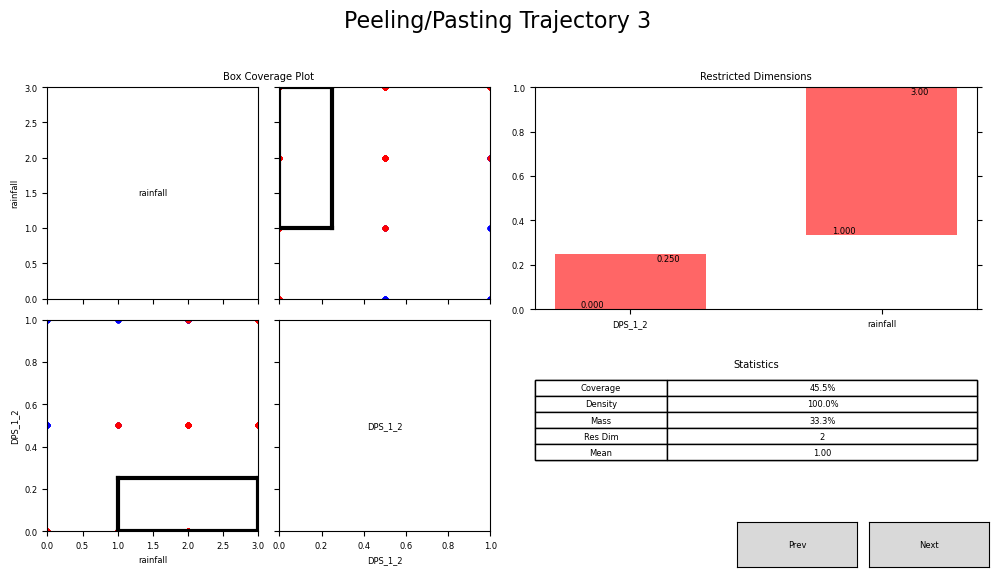

In [29]:
prim_alg = prim.Prim(prim_data, labels['vulnerable'], threshold=0.9, threshold_type=">")
box = prim_alg.find_box()
box_df=box.limits
# print(df.head())
box_df.to_csv('outputs/prim_box_BROADMOOR_allScenario_df.csv')
box.show_tradeoff()
box.show_details()
print(box)
plt.show()